In [1]:
import pypesto
import pypesto.petab
import pypesto.optimize as optimize
import pypesto.sample as sample
import pypesto.visualize as visualize

import petab
import numpy as np
from scipy.special import gammaln
from scipy.special import gamma
import pickle
import pandas as pd

datatype = "original"

In [2]:
# Load experimental data
df=pd.read_csv('data/data.csv', sep='\t')

add_offset_to_data = True
offset_value = 0.2

if add_offset_to_data:
    df.Measurement=df.Measurement+offset_value
    
data = np.asarray(df.Measurement)

tvec = np.asarray(df.Time)
    
N = len(tvec)

For this ODE we have an analytical solution. Given a proposed pair of $k_1, k_2$ we can simulate the values of $X_2$.

In [3]:
def analytical_x2(t, t0, kTL_m0, xi, delta):
    X = [np.exp(-delta*(t-t0)) * (t>t0),
         kTL_m0 * (np.exp(-xi*(t-t0)) - np.exp(-delta*(t-t0))) / (delta-xi) * (t>t0)]
    return X[1]

def simulate_model(x, tvec):
    # assign parameters
    t0, kTL_m0, xi, delta, _, _ = x
    # simulate model
    simulation = np.asarray([analytical_x2(t, t0, kTL_m0, xi, delta)
                             for t in tvec])
    return simulation

To sample the posterior we need to define a prior and likelihood function. For numerical reasons we will implement the negative log likelihood and negative log prior.

In [4]:
def log_prior(x):
    """ Log prior function."""
    # assign variables from input x
    offset = x[3]

    # exponential prior
    exp_prior = np.log(lamda) - lamda * offset

    return exp_prior


def negative_log_posterior(x):
    """ Negative log posterior function."""

    shape = x[4]
    offset = x[5]

    # simulate model
    _simulation = simulate_model(np.power(10, x), tvec)
    simulation = offset + np.asarray(_simulation)

    # evaluate standard log likelihood
    res = abs(data - simulation)
    sum_res = np.sum(res) / shape

    l_llh = -(N*(np.log(2) + np.log(shape)) + sum_res)

    # evaluate log normal-gamma prior
    l_prior = log_prior(x)

    # return NEGATIVE log posterior (required for pyPESTO)
    return -(l_llh + l_prior)

Now that we have the objective function defined, we need to create a pyPESTO problem.

In [5]:
def standard_sampling():
    """Creates a pyPESTO problem."""
    objective = pypesto.Objective(fun=negative_log_posterior)
    problem = pypesto.Problem(objective=objective,  # objective function
                              lb=[-2, -5, -5, -5, -np.inf, 0],  # lower bounds
                              ub=[np.log10(df.Time.max()), 5, 5, 5, np.inf, np.inf],  # upper bounds
                              x_names=['t_0', 'k_{TL}*m_0', 'xi', 'delta',
                                       'shape', 'offset'],  # parameter names
                              x_scales=['log10', 'log10', 'log10', 'log10',
                                        'lin', 'lin'])  # parameter scale
    return problem

In [6]:
### Prior dependent paramters

lamda = 0.01

# create the estimation problem
problem = standard_sampling()

# MCMC chain length
n_samples= 100000

In [20]:
x0 = [np.array([0.2998, 0.9949, -0.1074, -0.6910, 0.2, 1]),
      np.array([0.2998, 0.9949, -0.6910, -0.1074, 0.2, 1]),
      np.array([0.2998, 0.9949, -0.1074, -0.6910, 0.2, 1]),
      np.array([0.2998, 0.9949, -0.6910, -0.1074, 0.2, 1])]

cov0 = 1e-4

# call the sampler of choice
sampler = sample.AdaptiveParallelTemperingSampler(n_chains=4, internal_sampler=
                                                  sample.AdaptiveMetropolisSampler(options={'cov0': cov0}))

In [21]:
# Define number of runs
runs = 1

save_results = False # for testing just set to False

# Loop over n runs
for n in range(runs):
    # set initial random seed
    np.random.seed(n)
    # perform MCMC sampling
    result = sample.sample(problem, n_samples=n_samples, sampler=sampler,
                           x0=x0)
    # calculate effective sample size
    sample.effective_sample_size(result=result)

    # save the results as a pickle object
    if save_results:
        results = result.sample_result
        with open('Results/Full_parameter/' + str(n) + '.pickle','wb') as result_file:
            pickle.dump(results, result_file, n)

100%|██████████| 100000/100000 [18:50<00:00, 88.44it/s]


There are some built-in visualization functions that one can use.

5573.1749053997355
4.932627040776411


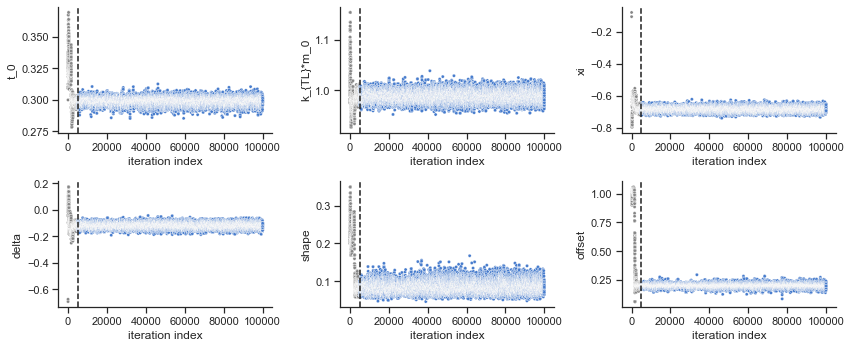

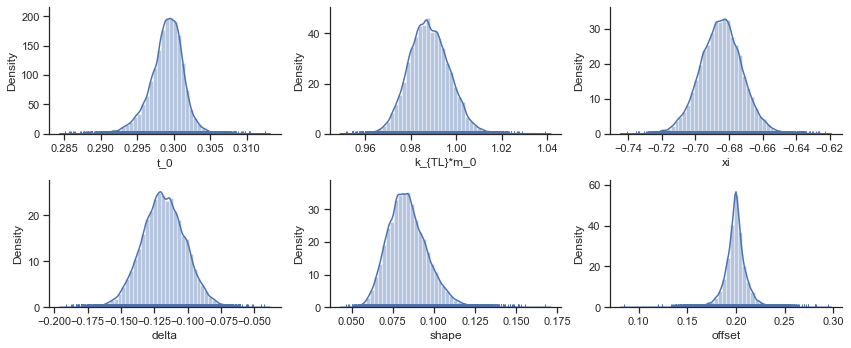

In [22]:
print(result.sample_result.effective_sample_size)
print(result.sample_result.effective_sample_size/result.sample_result.time)
# Visualize the parameter trace
ax = visualize.sampling.sampling_parameters_trace(result, use_problem_bounds=False, full_trace=True, size=(12,5))
# Visualize the one-dimensional marginals --> Important!
ax = visualize.sampling_1d_marginals(result, size=(12,5))

In [23]:
data

array([0.2   , 0.2   , 0.2   , 0.2   , 0.2   , 0.2   , 0.2   , 0.2   ,
       0.2   , 0.2   , 0.2   , 2.0309, 3.5559, 4.8091, 5.6235, 6.1757,
       6.8298, 7.208 , 8.028 , 7.7852, 8.1247, 8.0363, 8.2107, 7.9077,
       7.7316, 7.6208, 7.7734, 7.5197, 7.3489, 7.3987, 7.0493, 6.8425,
       6.8268, 6.3223, 6.3078, 6.1242, 5.8034, 5.6618, 5.3281, 5.1489,
       5.093 , 4.9747, 4.975 , 4.5095, 4.4211, 4.2416, 3.9485, 3.9164,
       3.6799, 3.7286, 3.4785])

[ 0.29898633  0.98489141 -0.68090103 -0.1239643   0.08165323  0.19944308]


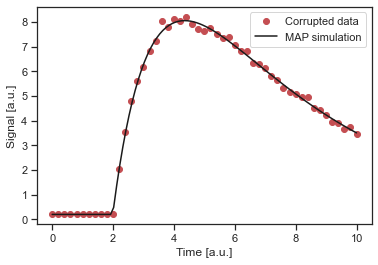

In [24]:
plot_MAP = True

if plot_MAP:
    MAP_index=np.argmax(-result.sample_result.trace_neglogpost[0,result.sample_result.burn_in:])
    MAP = result.sample_result.trace_x[0,result.sample_result.burn_in+MAP_index,:]
    print(MAP)

    tvec_for_simulation = np.linspace(tvec[0],tvec[-1],100)

    offset = MAP[-1]

    # simulate model
    _simulation = simulate_model(np.power(10, MAP), tvec_for_simulation)
    simulation = (offset + np.asarray(_simulation))
    
    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(tvec,data,'or',label='Corrupted data')
    plt.plot(tvec_for_simulation,simulation,'k',label='MAP simulation')
    plt.xlabel('Time [a.u.]')
    plt.ylabel('Signal [a.u.]')
    plt.legend()
    plt.show()